<a href="https://colab.research.google.com/github/tassiLuca/dia-project/blob/master/fetal_health_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetal Health Classification
## Progetto d'Esame di _Applicazioni di Data Intensive_
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

**Luca Tassinari** • **luca.tassinari10@studio.unibo.it**

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Import necessari per ignorare i warning di `ConvergenceWarning` durante la ricerca degli iper-parametri migliori nella GridSearch. Vedi funzione `get_tuned_model`.

In [82]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [83]:
import os
from urllib.request import urlretrieve
def download(file, url):
    ''' A simple function to download, from a given url, a file. '''
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Introduzione al caso di studio
### Contesto
La riduzione della mortalità infatile è uno degli [obiettivi](https://www.eda.admin.ch/agenda2030/it/home/agenda-2030/die-17-ziele-fuer-eine-nachhaltige-entwicklung/ziel-3--ein-gesundes-leben-fuer-alle-menschen-jeden-alters-gewae.html) di sviluppo sostenibile delle Nazioni Unite e, sicuramente, uno dei grandi indicatori del progresso umano.

In questo contesto, la [cardiotocografia (CTG)](https://it.wikipedia.org/wiki/Cardiotocografia) è un esame poco invasivo che viene effettuato durante il periodo prenatale e che, grazie a un trasduttore a ultrasuoni, permette di monitorare la frequenza cardiaca fetale (FHR), i movimenti fetali, le contrazioni uterine e altro ancora.

### I dati
Lo scopo è riuscire a creare un algoritmo di **classificazione** che permetta di identificare i bimbi a rischio e quelli in condizioni patologiche.
Per farlo si usa un dataset scaricato da [kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification) in cui 2126 registrazioni delle caratteristiche estratte dalle cardiotocografie sono state classificate da tre ostretici esperti in 3 classi:
- Normale
- Sospetto
- Patologico

In [84]:
download("data.csv.gz", "https://github.com/tassiLuca/dia-project/raw/master/datasets/fetal_health.csv.gz")

In [85]:
data = pd.read_csv("data.csv.gz", compression="gzip")

In [86]:
# by default pandas displays only 20 cols
pd.options.display.max_columns = len(data.columns)

Vengono qui riportate le descrizioni delle 22 _feature_ del dataset:
- `baseline value`: Baseline Fetal Heart Rate (FHR);
- `accelerations`: Number of accelerations per second;
- `fetal_movement`: Number of fetal movements per second; 
- `uterine_contractions`: Number of uterine contractions per second;
- `light_decelerations`: Number of LDs per second;
- `severe_decelerations`: Number of SDs per second;
- `prolongued_decelerations`: Number of PDs per second;
- `abnormal_short_term_variability`: Percentage of time with abnormal short term variability;
- `mean_value_of_short_term_variability`: Mean value of short term variability;
- `percentage_of_time_with_abnormal_long_term_variability`: Percentage of time with abnormal long term variability;
- `mean_value_of_long_term_variability`: Mean value of long term variability;
- `histogram_width`: Width of the histogram made using all values from a record;
- `histogram_min`: Histogram minimum value;
- `histogram_max`: Histogram maximum value;
- `histogram_number_of_peaks`: Number of peaks in the exam histogram;
- `histogram_number_of_zeroes`: Number of zeroes in the exam histogram;
- `histogram_mode`: Hist mode;
- `histogram_mean`: Hist mean;
- `histogram_median`: Hist median;
- `histogram_variance`: Hist variance;
- `histogram_tendency`: Histogram trend;
- **`fetal_health`: to predict**
    - 0: Normal
    - 1: Suspect
    - 2: Pathological

In [87]:
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


## Analisi esplorativa dei dati

Definiamo un dizionario per mappare le tre classi (1, 2, 3) in una descrizione più leggibile e in tre colori differenti (ci servirà più tardi per i grafici):

In [88]:
diagnosis_desc = {1.0: "normale", 2.0: "sospetto", 3.0: "patologico"}

In [89]:
diagnosis_color_map = {1.0: "green", 2.0: "orange", 3.0: "red"}

In [90]:
diagnosis_colors = data["fetal_health"].map(diagnosis_color_map)

Come si può notare tutte le _features_ del dataset sono numeriche, tranne che per `histogram_tendency` che può assumere 3 valori 0, 1 e -1:

In [91]:
data["histogram_tendency"].value_counts()

 0.0    1115
 1.0     846
-1.0     165
Name: histogram_tendency, dtype: int64

Visualizziamo la distribuzione dei dati nel dataset, attraverso un semplice grafico a torta.

In [92]:
dd = data["fetal_health"].map(diagnosis_desc).value_counts().to_frame(name="count")
dd["%"] = (dd["count"] / len(data)) * 100
dd

,count,%
normale,1655,77.845720
sospetto,295,13.875823
patologico,176,8.278457


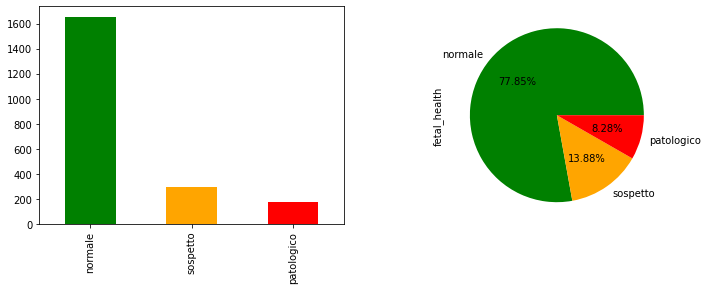

In [93]:
plt.figure(figsize=(12, 4))
data["fetal_health"].map(diagnosis_desc).value_counts().plot.bar(
    ax=plt.subplot(1, 2, 1),
    color=list(diagnosis_color_map.values())
)
data["fetal_health"].map(diagnosis_desc).value_counts().plot.pie(
    autopct="%.2f%%",
    ax=plt.subplot(1, 2, 2), 
    colors=list(diagnosis_color_map.values())
)

Come si può osservare, il 78% delle osservazioni del dataset sono state classificate come normali, il 14% come sospette e circa l'8% come patologiche. Su un totale di 2126 osservazioni, quindi, appena 176 sono state classificate come casi patologici e solo 295 come casi sospetti.

Siamo quindi in presenza di un dataset in cui la suddivisione di istanze tra le classi è molto **sbilanciata**. Questo può portare a molti più errori di classificazione sulla classe meno rappresentata - che nel caso in esame è proprio la classe più importante da predire - e a fornire stime di accuratezza fuorvianti. Per questo sarà fondamentale, nel seguito, adottare stime di accuratezza più raffinate (quali la _Precision_, _Recall_, _F1 Score_) e metodi per cercare di ridurre questo problema (come aumentare il peso degli errori sulla classe con meno istanze).

Statistiche per ogni _feature_:

In [94]:
data.iloc[:, :-1].describe()
#            ^^^^
# exclude the last col which contains the target

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


Come si può osservare dalla tabella delle statistiche aggregate delle colonne (e poi anche nel successivo _boxplot_) le variabili coinvolte utilizzano scale di valori molto diverse (ad es. `baseline value` è nell'ordine delle centinaia di unità, `accelerations` nell'ordine di centesimi di unità). Per ottenere modelli con migliore accuratezza sarà quindi necessario applicare la **standardizzazione** a tutte le variabili.

Grafichiamo con dei _boxplot_ i dati per individuare eventuali _outliers_. Si ricorda che gli estremi inferiore e superiore di ciascun rettangolo rappresentano il primo ($Q_1$) e terzo quartile ($Q_3$) dei dati (rispettivamente 25° e 75° percentile) e la linea centrale è la mediana. I cerchi molto distanti dalla mediana sono detti _outlier_: tutti quei valori $x$ t.c. $$x < Q_1 - 1,5 \cdot IQR \lor x > Q_3 + 1,5 \cdot IQR $$ dove $IQR = Q_3 - Q_1$

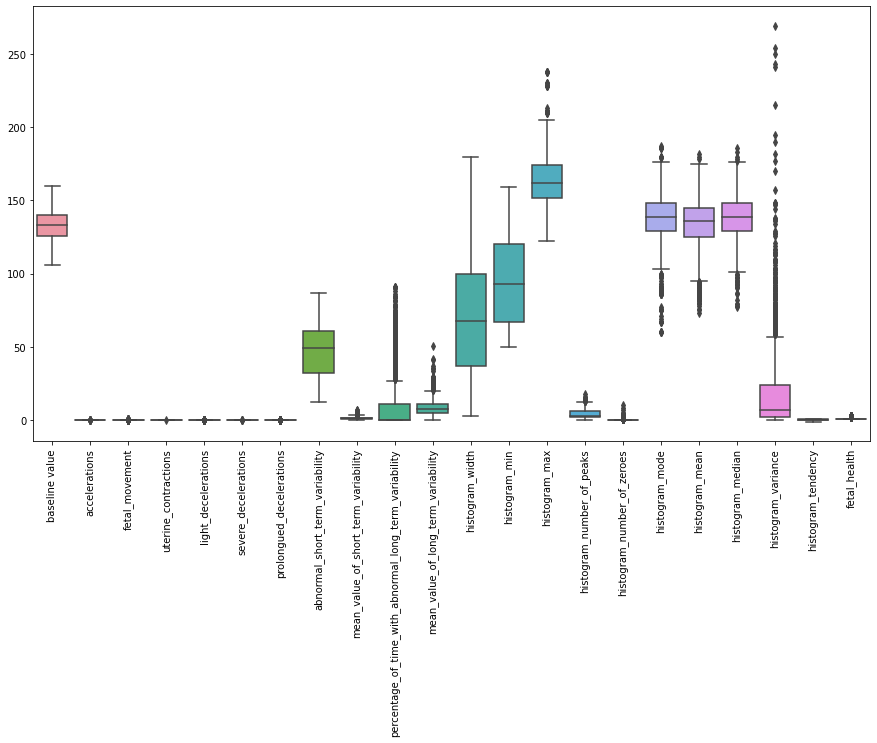

In [95]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.show()

Nonostante siano presenti valori anomali nel dataset (i.e. _outliers_), si ritiene opportuno **non** eliminarli: il dataset sopra presentato è il frutto di rilevazioni [CTG](https://it.wikipedia.org/wiki/Cardiotocografia) in cui ciascuna osservazione è stata etichettata da esperti, per cui si ritiene improbabile un errore di immissione dei dati, bensì siano proprio queste osservazioni anomale ad essere significative per il caso di studio.

Al fine di valutare quanto le variabili siano utili nella predizione grafichiamo, per ogni variabile predittiva, la distribuzione delle classi in un istogramma.

In [96]:
# data.pivot(columns="fetal_health")

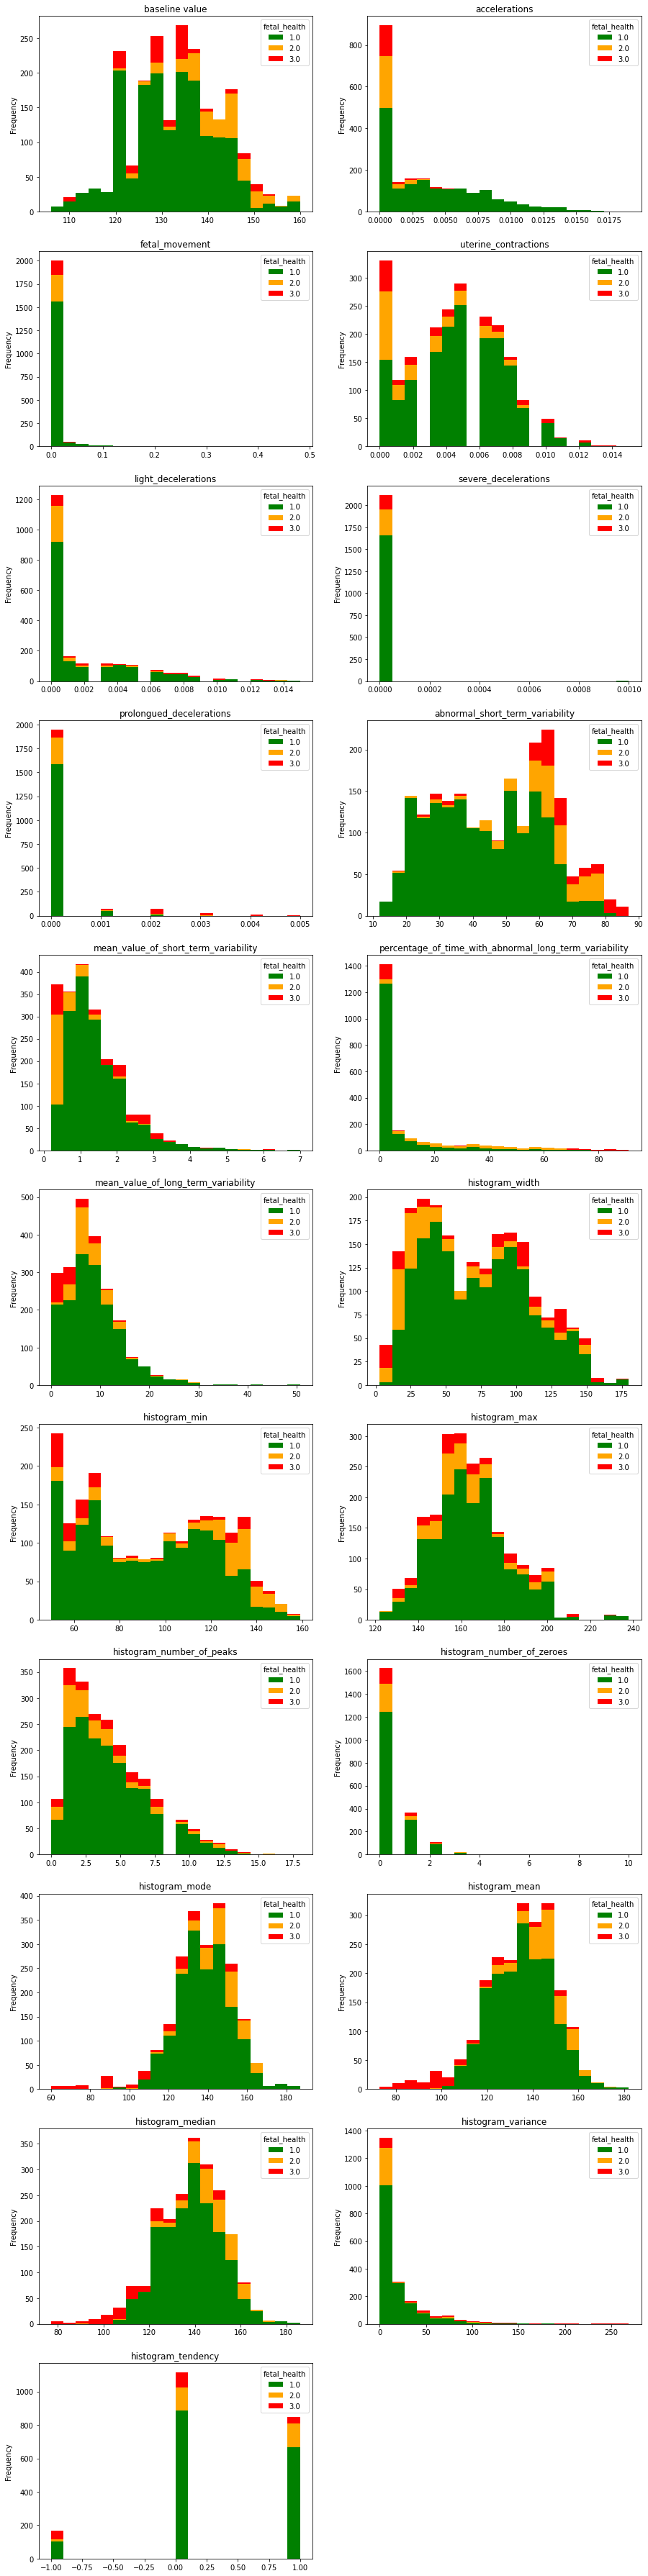

In [97]:
plt.figure(figsize=(15, 65))
for col, i in zip(data.columns[:-1], range(len(data.columns[:-1]))):
    data.pivot(columns="fetal_health")[col].plot.hist(
        bins=20, 
        stacked=True, 
        title=col, 
        ax=plt.subplot(11, 2, i+1),
        color=list(diagnosis_color_map.values())
    )

Le _feature_ che sembrano più significative per la salute fetale sono `baseline value`, `accelerations`, `abnormal_short_term_variability` e `histogram_mean`.
Infatti, rappresentando ad esempio la distribuzione congiunta di `abnormal_short_term_variability` e `histogram_mean` in un grafico a dispersione si ottiene:

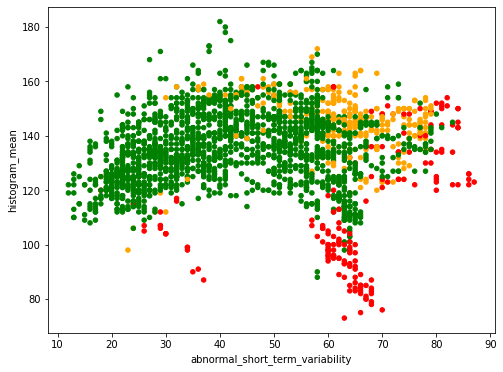

In [98]:
data.plot.scatter(
    "abnormal_short_term_variability", 
    "histogram_mean", 
    c=diagnosis_colors, 
    figsize=(8, 6)
);

Calcoliamo inoltre il coefficiente di correlazione di _Pearson_ tra ogni variabile e la variabile target da predire. Il coefficiente di _Pearson_ è un indice usato per valutare numericamente il grado di correlazione tra due variabili X e Y
- Il suo valore è compreso tra -1 e 1
  - valori vicini a 1 indicano correlazione diretta (Y cresce al crescere di X)
  - valori vicini a -1 indicano correlazione inversa (Y descresce al crescere di X)
  - valori vicini a 0 indicano assenza di correlazione

Per osservare al meglio quali _feature_ sono significative per ciascuna classe del problema, si è deciso di convertire la variabile categorica target `fetal_health` in 3 variabile numeriche binarie t.c. ciascuna delle variabili `fetal_health`$_i$:
- vale 1 se `fetal_health` = $i$;
- 0 altrimenti

In [99]:
from sklearn.preprocessing import OneHotEncoder

In [100]:
encoder = OneHotEncoder(sparse = False)
target_variables = pd.DataFrame(
    encoder.fit_transform(data[["fetal_health"]]),
    columns=encoder.get_feature_names_out()
)
target_variables

,fetal_health_1.0,fetal_health_2.0,fetal_health_3.0
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
2121,0.0,1.0,0.0
2122,0.0,1.0,0.0
2123,0.0,1.0,0.0
2124,0.0,1.0,0.0


In [101]:
data_combo = data.join(target_variables)
data_combo.drop(columns=["fetal_health"])
data_combo

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,...,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health,fetal_health_1.0,fetal_health_2.0,fetal_health_3.0
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,...,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0,0.0,1.0,0.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,...,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,1.0,0.0,0.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,...,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,1.0,0.0,0.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,...,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0,1.0,0.0,0.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,...,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,...,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0,0.0,1.0,0.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,...,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0,0.0,1.0,0.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,...,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0,0.0,1.0,0.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,...,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0,0.0,1.0,0.0


In [102]:
data_corr = data_combo.corr(method='pearson')

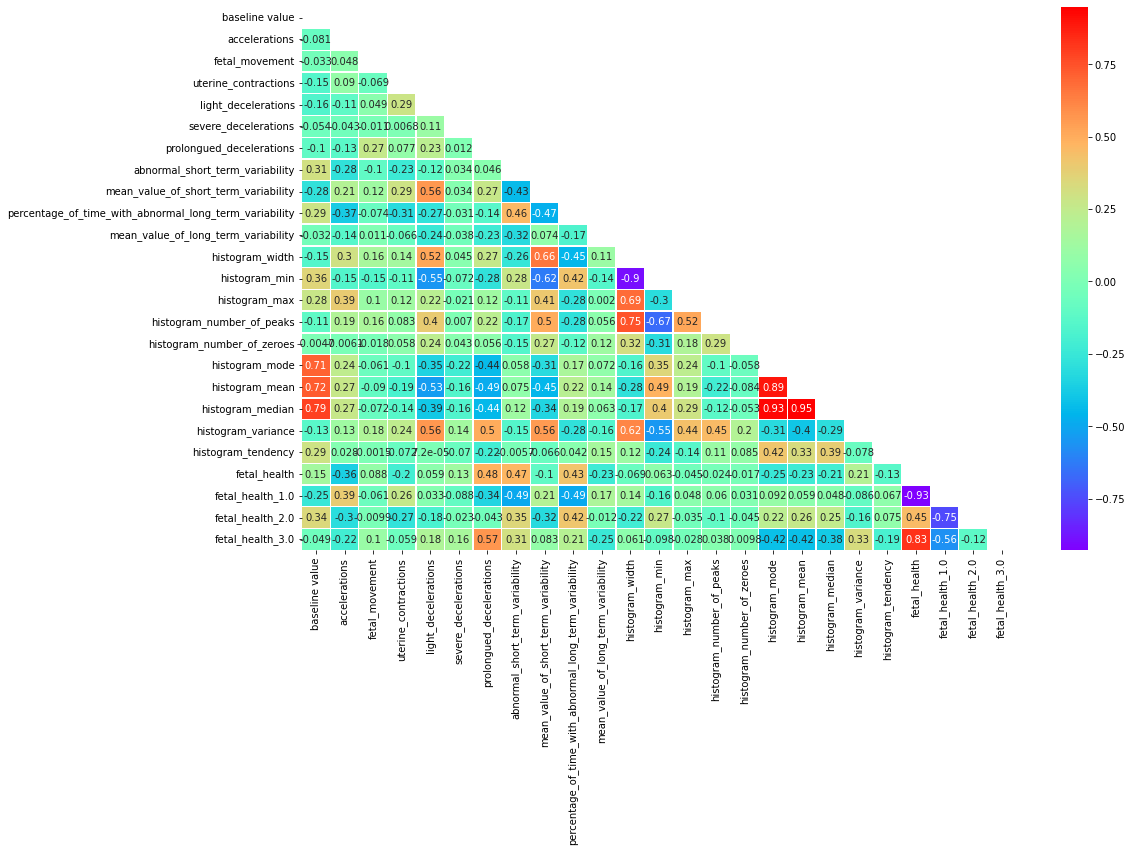

In [103]:
mask = np.zeros_like(data_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 10))
sns.heatmap(data_corr, mask=mask, cmap="rainbow", linewidths=0.30, annot=True)

In [104]:
x = data_corr[list(encoder.get_feature_names_out())].sort_values(
    list(encoder.get_feature_names_out()), 
    ascending=False
)
# drop fetal_health_0, fetal_health_1 and fetal_health rows
x = x.drop(list(encoder.get_feature_names_out()) + ["fetal_health"], axis=0)
x.style.background_gradient(cmap="rainbow")

,fetal_health_1.0,fetal_health_2.0,fetal_health_3.0
accelerations,0.394760,-0.301581,-0.216591
uterine_contractions,0.263639,-0.269365,-0.059397
mean_value_of_short_term_variability,0.207717,-0.315373,0.082600
mean_value_of_long_term_variability,0.172519,-0.011522,-0.245545
histogram_width,0.142182,-0.219384,0.060945
histogram_mode,0.092320,0.223125,-0.419051
histogram_tendency,0.066529,0.074653,-0.193919
histogram_number_of_peaks,0.060354,-0.102957,0.038205
histogram_mean,0.059107,0.261298,-0.416886
histogram_max,0.048106,-0.035153,-0.028399


Come era facile e logico aspettarsi, le _feature_ che hanno un'elevata correlazione con la classe `1`, Normale, hano una correlazione inversa con le altre due classi, Sospetto e Patologico, e viceversa.

## Preparazione

### Valutazione dei modelli di classificazione

- **Accuratezza**: quanto il modello è efficace nel prevedere le classi corrette delle osservazioni. 
- Siccome il valore di accuratezza dipende dal _validation set_ che si utilizza, l'obiettivo è stimare un intervallo di valori in cui l'acuretezza reale del modello cade con una percentuale $p$ di probabilità. Tale percentuale è detto **livello di confidenza** e l'intervallo stimato è dtto **intervallo di confidenza**
- Intervallo di confidenza si calcola: $$ \frac{2Na+Z^2\pm Z\sqrt{Z^2+4Na+4Na^2}}{2(N+Z^2)} $$ dove:
    - $a$ è l'accuratezza del modello misurata sul validation set
    - N è il numero di osservazioni nel validation set
    - Z è il valore tale per cui l'area sottesa dalla densità di probabilità $\varphi(x)$ della distribuzione normale standard tra -Z e Z sia il livello di confidenza 1-𝛼. Con un livello di confidenza pari a 95%, $Z=1.96$. In generale tale valore lo s può ottenere in python con: 
    ```python
        from scipy.stats import norm
        norm.ppf(0.975)   # 1 - 0.05/2
    ```
- **Precision**: percentuale di esempi classificati come una classe `C` che sono realmente tali
- **Recall**: percentuale di esempi realmente di classe `C` che sono stati rilevati dall'algoritmo
- Un modo per visualizzare Precision e Recall è utilizzare la **Matrice di Confusione**: ogni colonna della matrice rappresenta i valori predetti, mentre ogni riga rappresenta i valori reali. L'elemento sulla riga $i$ e sulla colonna $j$ è il numero di casi in cui il classificatore ha classificato la classe "vera" $i$ come classe $j$.
- **_F1-measure_**: media armonica tra Precision e Recall

Definiamo alcune funzioni di supporto per calcolare e stampare a le statistiche di accuratezza.

In [105]:
def conf_interval(a, N, Z=1.96):
    '''
    Computes the confidence interval of a model, given its parameters.

        Parameters:
            a: model accuracy measured on validation set
            N: number of rows (observations) in the validation set
            Z: z distribution

        Returns:
            (a, b): tuple with the confidence interval.
    '''
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [106]:
def plot_confusion_matrix(confusion_matrix):
    '''
    Plot the confusion matrix given in input as an heatmap.
    '''
    sns.heatmap(confusion_matrix, cmap="Greens", annot=True)
    plt.xlabel('Classe **predetta**')
    plt.ylabel('Classe **reale**')
    plt.title("Confusion Matrix")

In [107]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
def print_eval(X_val, y_val, model):
    '''
    Function to print prediction accuracy stats.
    '''
    print("++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++")
    score = model.score(X_val, y_val)
    print(f"> Score: {score:4.4f} ({score * 100: 5.2f}%)")
    confidence = conf_interval(score, len(X_val))
    print(f"\n> Intervallo accuratezza (confidenza 95%): \n{confidence}")
    cf = pd.DataFrame(
        confusion_matrix(y_val, model.predict(X_val)), 
        index=model.classes_, 
        columns=model.classes_
    )
    print(f"\n> Confusion Matrix: \n{cf}")
    plot_confusion_matrix(cf)
    recall = recall_score(y_val, model.predict(X_val), average=None)
    precision = precision_score(y_val, model.predict(X_val), average=None)
    print(f"\n> Recall:    {recall}")
    print(f"> Precision: {precision}")
    score_f1 = f1_score(y_val, model.predict(X_val), average=None)
    print(f"\n> f1_score per feature: \n{score_f1}")
    score_f1_agg = f1_score(y_val, model.predict(X_val), average="macro")
    print(f"\n> f1_score macro: {score_f1_agg:3.3f}")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

### Suddivisione dati 

Suddivido in training e validation set i dati.

In [108]:
X = data.drop(["fetal_health"], axis=1)
y = data["fetal_health"]

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,               # data to split
    test_size = 1/3,    # 2/3 training set, 1/3 validation set
    random_state = 42   # seed for reproducibility
)

In [110]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

@ignore_warnings(category=ConvergenceWarning)
def get_tuned_model(model, params_grid, X_train, y_train):
    '''
    Create a stratified k-fold and find the best params with grid search.

        Parameters:
            model: the model to tune
            params_grid: the grid of parameters (dictionary)
            X_train: the training set with all the features
            y_train: the training set with the target feature to predict

        Returns:
            (gs, gs.best_params_, ranking): a tuple containing the fitted model, 
            a dictionary with the best results on the hod out data 
            and a dataframe containg the ranking of the top 5 parameters.
    '''
    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    gs = GridSearchCV(model, params_grid, cv=skf)
    gs.fit(X_train, y_train)
    ranking = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
    return gs, gs.best_params_, ranking

In [111]:
def get_features_scores(model):
    '''
    Computes and plots on a bar chart the features weight of the model 
    given in input.

        Parameters:
            model: the fitted model fro which extract the teh features score
        
        Returns:
            fs: a dataframe with the weigth of each feature
    '''
    fs = pd.DataFrame(
        model.best_estimator_[-1].coef_.T,
        columns=diagnosis_desc.values(), 
        index=X.columns
    )
    fs.plot.bar(figsize=(15,8), grid=True, stacked=True, width=.8)
    return fs

## Modelli 

Nel seguito verranno usati 5 algoritmi per classificare le istanze, basati su due famiglie differenti:
- Classificazione con iperpiani
    1. Perceptron
    2. Regressione logistica
    3. SVM
- Alberi decisionali
    4. DecisionTreeClassifier
    5. XGBoost

Gli ultimi due sfruttano gli alberi decisionali: creano una struttura ad albero tale da segmentare lo spazio mediante un insieme di regole (percorsi) che sfruttano le relazioni tra una classe e le variabili.

L'obiettivo dei primi tre è quello invece di individuare un iperpiano di separazione che massimizzi la separazione tra le classi. Per problemi di classificazione multi-classe (come nel nostro caso) vi sono 2 approcci:
- **One-Versus-All**: per ciascuna classe `C` si addestra un modello indipendente dagli altri a distinguere `C` da `non C`.
- **Multinomial**: viene calcolata e minimizzata un'unica funzione di errore su tutti gli iperpiani.

N.B. Non tutti gli algoritmi supportano entrambi i metodi!

In tutti i casi utilizzeremo la _cross validation_ a _$k$ fold_ per la validazione del modello e la _grid search_ per individuare la miglior combinazione di iper-parametri da utilizzare (ad esempio per la regolarizzazione).
Un iper-parametro importante da sottolineare, comune a tutti gli algoritmi di classificazione, è `class_weight`, ovvero il peso da associare a ciascuna classe. Come già osservato nell'Analisi esplorativa dei dati, siccome siamo in presenza di una suddivisione sbilanciata delle istanze delle classi, è opportuno valutare la convenzianza di penalizzare l'errata classificazione operata sulla classe minoritaria fissando un peso più elevato per questa e riducendo il peso per la classe maggioritaria.

---
[[Multiclass and multioutput algorithms documentation](https://scikit-learn.org/stable/modules/multiclass.html)]


### Perceptron

---

[[_Perceptron_ doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron)]

_Perceptron_ è un algoritmo di classificazione molto semplice, concettualmente simile alla discesa del gradiente. 

**NOTA: _Percepetron_ usa la versione ONE-VERSUS-ALL**.

In [112]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Iperparametri:
- `penalty` (default=`None`): Tipo di regolarizzazione da usare => {`'l2'`,`'l1'`,`'elasticnet'`}
- `alpha` (default=`0.0001`): Costante che moltiplica il termine di regolarizzazione se usata ($\lambda$ nelle _slides_ di teoria)
- `l1_ratio` (default=`0.15`): Il parametro di proporzione della regolarizzazione _Elastic Net_: $0 \leq$ `l1_ratio` $\leq 1$. `l1_ratio=0` corrisponde a regolarizzazione L2, `l1_ratio=1` a L1. **Da usare solo quando `penalty='elasticnet'`**.
- `class_weight` (default=`None`): Pesi associati a ciascuna classe: `dict, {class_label: weight}` o `"balanced"`. Se non fornita tutte le classi hanno peso unitario. 
    > The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.

    Nel nostro caso: `n_samples` = `len(y_train)` = 2/3 $\cdot$ `len(y)` = 1417, `n_classes` = 3, `n_rows_class_2` = 1095, `n_rows_class_3` = 191, `n_rows_class_1` = 131. Quindi:

|     Classe     |      Peso     |
|----------------|:-------------:|
| 1 (normale)    |   0.43135464  |
| 2 (sospetto)   |   2.47294939  |
| 3 (patologico) |   3.60559796  |
        




In [113]:
print(f"len(y) = {len(y)}, len(y_train) = {len(y_train)}")
# please note the first element is 0 because classes starts from 1
print(f"rows per class = {np.bincount(y_train)}")

len(y) = 2126, len(y_train) = 1417
rows per class = [   0 1095  191  131]


In [114]:
perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("prc", Perceptron(random_state=42))
])

In [115]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "prc__penalty": [None],
        "prc__class_weight": [None, "balanced"]
    },
    {
        "scaler": [None, StandardScaler()],
        "prc__penalty": ["l2", "l1"],
        "prc__alpha": np.logspace(-2, 2, 5),
        "prc__class_weight": [None, "balanced"]
    },
    {
        "scaler": [None, StandardScaler()],
        "prc__penalty": ["elasticnet"],
        "prc__alpha": np.logspace(-2, 3, 6),
        "prc__l1_ratio": [0.2, 0.4, 0.6, 0.8],
        "prc__class_weight": [None, "balanced"]
    }
]

In [116]:
%%time
perceptron, perceptron_best_params, perceptron_ranking = \
    get_tuned_model(perceptron_model, params_grid, X_train, y_train)

CPU times: user 10.3 s, sys: 51 ms, total: 10.4 s
Wall time: 10.3 s


La miglior combinazione di iper-parametri ottenuti è:

In [117]:
perceptron_best_params

{'prc__class_weight': 'balanced',
 'prc__penalty': None,
 'scaler': StandardScaler()}

Di seguito le combinazioni di parametri testate, ordinate per _score_: la prima riga corrisponde ai parametri scegli per il modello.

In [118]:
perceptron_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_prc__class_weight,param_prc__penalty,param_scaler,param_prc__alpha,param_prc__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.012052,0.002402,0.002644,0.000645,balanced,None,StandardScaler(),NaN,NaN,"{'prc__class_weight': 'balanced', 'prc__penalt...",0.830986,0.852113,0.858657,0.883392,0.915194,0.868068,0.028893,1
1,0.010916,0.002644,0.002336,0.000464,None,None,StandardScaler(),NaN,NaN,"{'prc__class_weight': None, 'prc__penalty': No...",0.852113,0.866197,0.862191,0.851590,0.883392,0.863097,0.011622,2
7,0.012506,0.000774,0.002182,0.000046,None,l1,StandardScaler(),0.01,NaN,"{'prc__alpha': 0.01, 'prc__class_weight': None...",0.866197,0.852113,0.777385,0.897527,0.883392,0.855323,0.041885,3
11,0.013068,0.001387,0.002256,0.000093,balanced,l1,StandardScaler(),0.01,NaN,"{'prc__alpha': 0.01, 'prc__class_weight': 'bal...",0.845070,0.816901,0.823322,0.876325,0.862191,0.844762,0.022521,4
49,0.012898,0.001192,0.002545,0.000560,None,elasticnet,StandardScaler(),0.01,0.6,"{'prc__alpha': 0.01, 'prc__class_weight': None...",0.806338,0.834507,0.780919,0.862191,0.897527,0.836296,0.040956,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.011420,0.002150,0.002167,0.000506,balanced,elasticnet,None,10.0,0.4,"{'prc__alpha': 10.0, 'prc__class_weight': 'bal...",0.091549,0.095070,0.134276,0.773852,0.091873,0.237324,0.268746,136
16,0.007362,0.000433,0.001868,0.000079,balanced,l2,None,0.1,NaN,"{'prc__alpha': 0.1, 'prc__class_weight': 'bala...",0.771127,0.095070,0.134276,0.091873,0.091873,0.236844,0.267623,137
40,0.007757,0.000241,0.002000,0.000048,balanced,l2,None,100.0,NaN,"{'prc__alpha': 100.0, 'prc__class_weight': 'ba...",0.137324,0.095070,0.134276,0.091873,0.134276,0.118564,0.020543,138
24,0.010033,0.001948,0.002437,0.000334,balanced,l2,None,1.0,NaN,"{'prc__alpha': 1.0, 'prc__class_weight': 'bala...",0.137324,0.095070,0.134276,0.091873,0.134276,0.118564,0.020543,138


Grafichiamo il peso delle _feature_ associate dall'algoritmo:

,normale,sospetto,patologico
baseline value,0.062507,-24.603409,51.086725
accelerations,18.250901,-46.131669,-21.419853
fetal_movement,-0.520066,1.571182,7.381192
uterine_contractions,4.929926,-0.544208,-10.068736
light_decelerations,1.827555,-2.166842,-1.851004
severe_decelerations,-7.034775,-12.492776,24.768619
prolongued_decelerations,-11.498351,10.798732,6.158270
abnormal_short_term_variability,-6.915436,9.320080,25.317053
mean_value_of_short_term_variability,-0.238560,-7.036874,-21.449691
percentage_of_time_with_abnormal_long_term_variability,-1.880432,-0.257897,14.400608


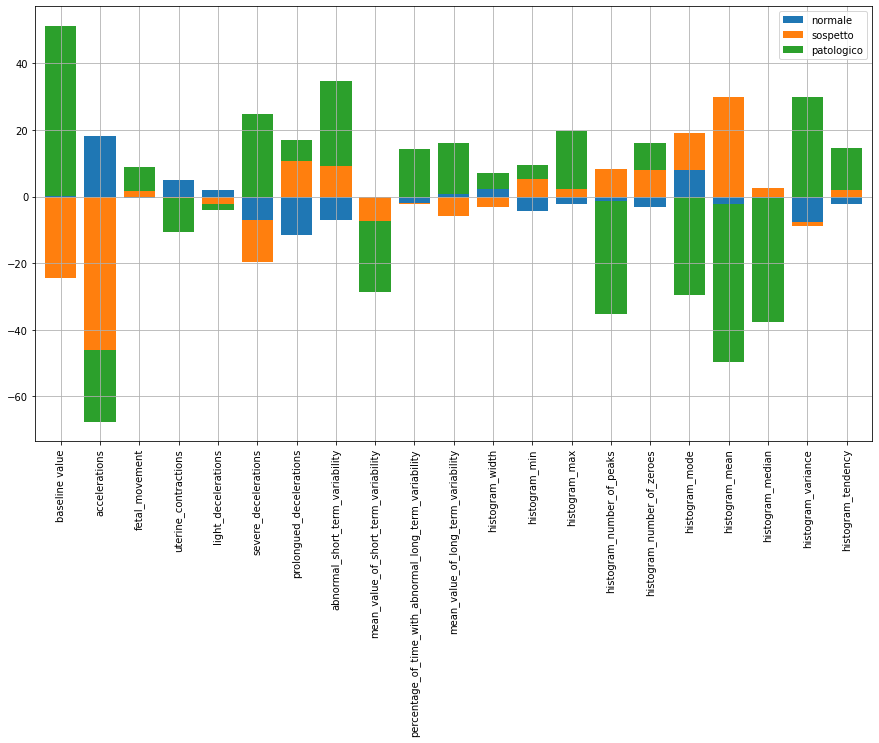

In [119]:
get_features_scores(perceptron)

Come si può osservare i pesi delle _feature_ sono chiaramente in linea con la matrice di correlazione presentata sopra.

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8561 ( 85.61%)

> Intervallo accuratezza (confidenza 95%): 
(0.8283810800356536, 0.8800512000108532)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  483   70    7
2.0    7   93    4
3.0    0   14   31

> Recall:    [0.8625     0.89423077 0.68888889]
> Precision: [0.98571429 0.52542373 0.73809524]

> f1_score per feature: 
[0.92       0.66192171 0.71264368]

> f1_score macro: 0.765
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


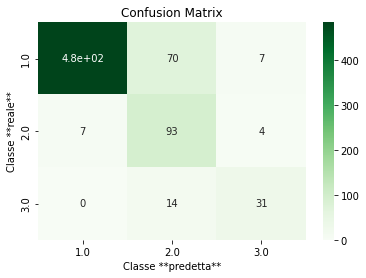

In [120]:
print_eval(X_val, y_val, perceptron)

Come si può dedurre dalla matrice di confusione:
- delle totali 45 osservazioni patologiche presenti nel _validation set_, 31 sono state correttamente classificate come tali, 14 sono state erroneamente classificate come sospette.
- delle totali 104 osservazioni sospette presenti nel _validation set_, 93 sono state classificate correttamente, 4 sono state erroneamente classificate come patologiche e 7 come normali.

Si noti che la precisione della classe 2 (i.e. le osservazioni sospette) è pari a circa il 52%. Su questo risultato ha un forte impatto il fatto che, delle 560 osservazioni normali del validation set, 70 sono state classificate erroneamente come sospette. In questo contesto, tuttavia, non rappresenta un grande problema: per ovvie ragioni è infatti molto più grave che osservazioni sospette o patologiche vengano classificate come normali, anziché osservazioni normali vengano etichettate come sospette.

### Logistic Regression

---

[[_LogisticRegression_ doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)]

In [121]:
from sklearn.linear_model import LogisticRegression

In [122]:
logistic_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga", random_state=42))
])

Descrizione (iper-)parametri:
- `solver`: algoritmo da usare per l'addrestramento. `"saga"` è l'unico che supporta tutti e tre i tipi di regolarizzazione.
- `multi-class`: metodo `"ovr"` (_One-Versus-All_), `"multinomial"` (_Multinomial_) (vedi sopra per descrizione).
- `C` (default=`1.0`): **inverso** del fattore moltiplicativo del termine di regolarizzazione. Piccoli valori indicano una maggiore regolarizzazione e viceversa!

I restanti parametri sono identici a quelli elencati per _Perceptron_.

In [123]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"],
        "lr__multi_class": ["ovr", "multinomial"],
        "lr__class_weight": [None, "balanced"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-2, 2, 5),
        "lr__multi_class": ["ovr", "multinomial"],
        "lr__class_weight": [None, "balanced"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-2, 2, 5),
        "lr__l1_ratio": [0.4, 0.5, 0.6, 0.7],
        "lr__multi_class": ["ovr", "multinomial"],
        "lr__class_weight": [None, "balanced"]
    }
]

**Nota bene**: per l'addestramento impiega circa 2-3 minuti.

In [124]:
%%time
logistic, logistic_best_params, logistic_ranking = \
    get_tuned_model(logistic_model, params_grid, X_train, y_train)

CPU times: user 2min 27s, sys: 186 ms, total: 2min 27s
Wall time: 2min 26s


In [125]:
logistic_best_params

{'lr__C': 0.1,
 'lr__class_weight': None,
 'lr__l1_ratio': 0.6,
 'lr__multi_class': 'multinomial',
 'lr__penalty': 'elasticnet',
 'scaler': StandardScaler()}

**Nota**: in questo caso le performance migliori si ottengono *senza* bilanciamento delle classi, adottando la regressione *Elastic Net*, che combina insieme le regolarizzazione L2 e L1 con peso, rispettivamente, 0,4 e 0,6.

In [126]:
logistic_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__class_weight,param_lr__multi_class,param_lr__penalty,param_scaler,param_lr__C,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
131,0.101356,0.000665,0.002267,0.000036,None,multinomial,elasticnet,StandardScaler(),0.1,0.6,"{'lr__C': 0.1, 'lr__class_weight': None, 'lr__...",0.887324,0.887324,0.858657,0.908127,0.922261,0.892739,0.021580,1
47,0.106334,0.002747,0.002272,0.000038,None,multinomial,l1,StandardScaler(),1.0,NaN,"{'lr__C': 1.0, 'lr__class_weight': None, 'lr__...",0.894366,0.887324,0.872792,0.897527,0.911661,0.892734,0.012734,2
157,0.152784,0.003556,0.002264,0.000026,None,ovr,elasticnet,StandardScaler(),1.0,0.5,"{'lr__C': 1.0, 'lr__class_weight': None, 'lr__...",0.869718,0.890845,0.865724,0.908127,0.925795,0.892042,0.022761,3
127,0.104043,0.005123,0.002295,0.000045,None,multinomial,elasticnet,StandardScaler(),0.1,0.5,"{'lr__C': 0.1, 'lr__class_weight': None, 'lr__...",0.890845,0.887324,0.858657,0.908127,0.915194,0.892030,0.019662,4
73,0.124868,0.002993,0.002385,0.000118,None,ovr,l2,StandardScaler(),100.0,NaN,"{'lr__C': 100.0, 'lr__class_weight': None, 'lr...",0.880282,0.890845,0.869258,0.897527,0.918728,0.891328,0.016724,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.033956,0.006310,0.002541,0.000485,None,multinomial,l1,StandardScaler(),0.01,NaN,"{'lr__C': 0.01, 'lr__class_weight': None, 'lr_...",0.785211,0.788732,0.787986,0.791519,0.791519,0.788994,0.002373,244
11,0.033639,0.004603,0.002200,0.000021,None,ovr,l1,StandardScaler(),0.01,NaN,"{'lr__C': 0.01, 'lr__class_weight': None, 'lr_...",0.781690,0.788732,0.784452,0.784452,0.787986,0.785463,0.002582,245
54,0.106309,0.003238,0.002139,0.000075,balanced,multinomial,l1,None,1.0,NaN,"{'lr__C': 1.0, 'lr__class_weight': 'balanced',...",0.767606,0.845070,0.773852,0.780919,0.756184,0.784726,0.031247,246
114,0.113307,0.002889,0.002161,0.000043,balanced,multinomial,elasticnet,None,0.01,0.6,"{'lr__C': 0.01, 'lr__class_weight': 'balanced'...",0.785211,0.757042,0.766784,0.805654,0.770318,0.777002,0.016946,247


,normale,sospetto,patologico
baseline value,-0.101485,0.000000,0.408460
accelerations,1.322095,-0.636300,0.000000
fetal_movement,-0.269574,0.000000,0.049295
uterine_contractions,0.546761,0.000000,0.000000
light_decelerations,0.000000,-0.154327,0.000000
severe_decelerations,0.000000,0.000000,0.077888
prolongued_decelerations,-0.816869,0.000000,0.276399
abnormal_short_term_variability,-1.021893,0.000000,0.652057
mean_value_of_short_term_variability,0.082227,0.000000,0.000000
percentage_of_time_with_abnormal_long_term_variability,-0.334017,0.000000,0.477822


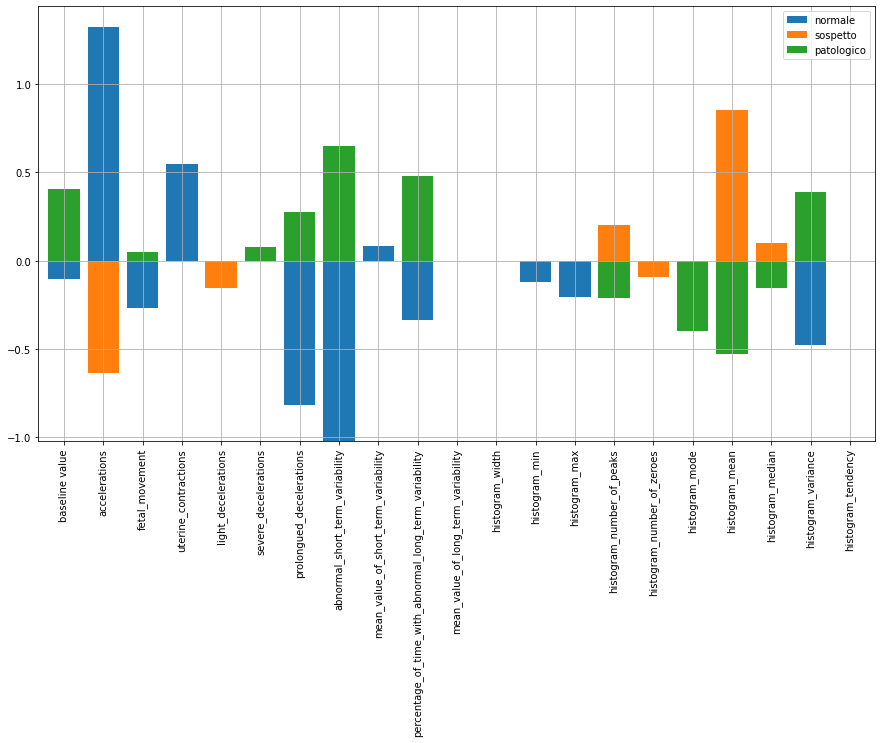

In [127]:
get_features_scores(logistic)

Come si evince dal grafico:
- il contributo della regolarizzazione L2 fa sì che i pesi associati alle _feature_ non diventino eccessivamente grandi (e generino _overfitting_) - a differenza, infatti, del metodo _Perceptron_ i pesi sono qui molto più minori in valore assoluto.
- il contributo della regolarizzazione L1 permette di annullare le _feature_ meno significative ai fini della classificazione.

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8970 ( 89.70%)

> Intervallo accuratezza (confidenza 95%): 
(0.8724858275608958, 0.9173109519761009)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  535   20    5
2.0   31   68    5
3.0    6    6   33

> Recall:    [0.95535714 0.65384615 0.73333333]
> Precision: [0.93531469 0.72340426 0.76744186]

> f1_score per feature: 
[0.94522968 0.68686869 0.75      ]

> f1_score macro: 0.794
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


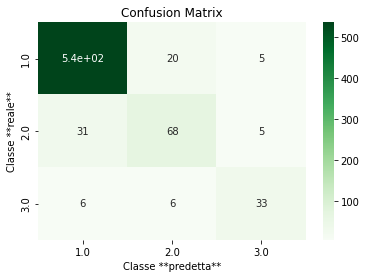

In [128]:
print_eval(X_val, y_val, logistic)

Rispetto a _Perceptron_:
- Classe 1 (normale): la _Recall_ è migliorata, la _Precision_ è leggermente peggiorata a causa del peggioramento della _Recall_ della classe 2;
- Classe 2 (sospetto): la _Precision_ è migliorata (perché la _Recall_ della classe 1 è migliorata), ma la _Recall_ è significativamente peggiorata; su un totale di 104 osservazioni sospette del _validation set_ 31 sono state erronemente classificate come normali (circa il 30%).
- Classe 3 (patologico): _Precision_ e _Recall_ sono leggermente migliori

Interessante osservare che, utilizzando la combinazione di parametri con `class_weight = "balanced"` con _score_ migliore (estratti dal dataframe sopra con la classifica e qui sotto riportati), la _Recall_ aumenta notevolmente a fronte di una netta diminuzione della `Precision`.
```
{
    'lr__C': 1.0, 
    'lr__class_weight': 'balanced', 
    'lr__l1_ratio': 0.6, 
    'lr__multi_class': 'ovr', 
    'lr__penalty': 'elasticnet', 
    'scaler': StandardScaler()
}
```

In [129]:
logistic_balanced = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        solver="saga", 
        random_state=42,
        C=1.0,
        class_weight="balanced",
        l1_ratio=0.6,
        multi_class="ovr",
        penalty="elasticnet"))
])
logistic_balanced.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', l1_ratio=0.6,
                                    multi_class='ovr', penalty='elasticnet',
                                    random_state=42, solver='saga'))])

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8519 ( 85.19%)

> Intervallo accuratezza (confidenza 95%): 
(0.8238636298548861, 0.8761516330029494)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  477   65   18
2.0    5   86   13
3.0    1    3   41

> Recall:    [0.85178571 0.82692308 0.91111111]
> Precision: [0.98757764 0.55844156 0.56944444]

> f1_score per feature: 
[0.91466922 0.66666667 0.7008547 ]

> f1_score macro: 0.761
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


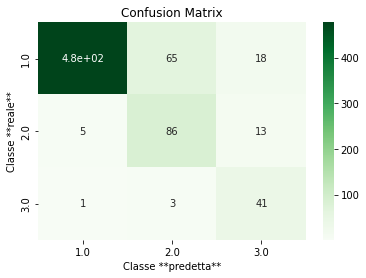

In [130]:
print_eval(X_val, y_val, logistic_balanced)

Su 104 osservazioni sospette solo 5 vengono classificate come normali e 13 come patologiche; inoltre, sulle 45 osservazioni patologiche del _validation set_ solo 1 viene etichettata come normale e 3 come sospette. A fronte di questi miglioramenti vi è un aumento, stimabile in circa il 30% rispetto al modello senza bilanciamento delle classi, di istanze normali (classe 1) che vengono mal classificate come sospette o patologiche (classi 2, 3).

Chiaramente questo _trade-off_ deve essere bilanciato in base alle esigenze: se l'obiettivo è riuscire a classificare il maggior numero di istanze sospette e patologiche anche ammettendo dei falsi positivi (banalmente perché si ritiene che sia meglio eccedere in prudenza, considerando un'istanza sospetta anche se normale) allora sarebbe opportuno utilizzare `class_weight = "balance"` e fare il _tuning_ degli altri parametri; se invece si ritiene opportuno non eccedere in prudenza, allora è effettivamente migliore il modello senza bilanciamento delle classi.

Nel proseguo si consideranno migliori i modelli con _Score F1_ migliore.

### SVM: Support Vector Machine

---
[SVC doc](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)


In [131]:
from sklearn.svm import LinearSVC

**Nota**: `LinearSVC` supporta solo regolarizzazione L2 o L1.

> **multi_class{‘ovr’, ‘crammer_singer’}, default=’ovr’**.
> 
> Determines the multi-class strategy if y contains more than two classes. "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored.

Gli altri parametri sono indetici a quelli di `LogisticRegression`.


In [132]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", LinearSVC(multi_class="ovr", dual=False, random_state=42))
])

In [133]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "svc__penalty": ["l1"],
        "svc__C": np.logspace(-2, 2, 5),
        "svc__class_weight": [None, "balanced"]
    }
]

In [134]:
%%time
svm, svm_best_params, svm_ranking = \
    get_tuned_model(svm_model, params_grid, X_train, y_train)

CPU times: user 17.6 s, sys: 26 ms, total: 17.6 s
Wall time: 17.6 s


In [135]:
svm_best_params

{'scaler': StandardScaler(),
 'svc__C': 1.0,
 'svc__class_weight': None,
 'svc__penalty': 'l1'}

In [136]:
svm_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,param_svc__C,param_svc__class_weight,param_svc__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.111757,0.029093,0.002302,0.000023,StandardScaler(),1.0,None,l1,"{'scaler': StandardScaler(), 'svc__C': 1.0, 's...",0.894366,0.887324,0.865724,0.897527,0.922261,0.893441,0.018187,1
16,0.241395,0.019765,0.002336,0.000111,StandardScaler(),10.0,None,l1,"{'scaler': StandardScaler(), 'svc__C': 10.0, '...",0.894366,0.883803,0.865724,0.893993,0.922261,0.892030,0.018346,2
18,0.166344,0.047744,0.002540,0.000492,StandardScaler(),100.0,None,l1,"{'scaler': StandardScaler(), 'svc__C': 100.0, ...",0.897887,0.883803,0.865724,0.890459,0.922261,0.892027,0.018495,3
8,0.329593,0.005601,0.002130,0.000039,None,100.0,None,l1,"{'scaler': None, 'svc__C': 100.0, 'svc__class_...",0.880282,0.883803,0.869258,0.890459,0.929329,0.890626,0.020533,4
12,0.046933,0.008004,0.002270,0.000025,StandardScaler(),0.1,None,l1,"{'scaler': StandardScaler(), 'svc__C': 0.1, 's...",0.876761,0.890845,0.851590,0.908127,0.918728,0.889210,0.023673,5
9,0.332885,0.006497,0.002118,0.000014,None,100.0,balanced,l1,"{'scaler': None, 'svc__C': 100.0, 'svc__class_...",0.869718,0.883803,0.872792,0.886926,0.918728,0.886393,0.017410,6
17,0.252318,0.009285,0.002354,0.000075,StandardScaler(),10.0,balanced,l1,"{'scaler': StandardScaler(), 'svc__C': 10.0, '...",0.873239,0.887324,0.869258,0.886926,0.901060,0.883561,0.011339,7
15,0.117484,0.021668,0.002303,0.000021,StandardScaler(),1.0,balanced,l1,"{'scaler': StandardScaler(), 'svc__C': 1.0, 's...",0.873239,0.887324,0.869258,0.886926,0.901060,0.883561,0.011339,7
19,0.160614,0.055591,0.002304,0.000035,StandardScaler(),100.0,balanced,l1,"{'scaler': StandardScaler(), 'svc__C': 100.0, ...",0.873239,0.887324,0.869258,0.886926,0.901060,0.883561,0.011339,7
6,0.337079,0.004716,0.002355,0.000480,None,10.0,None,l1,"{'scaler': None, 'svc__C': 10.0, 'svc__class_w...",0.862676,0.876761,0.862191,0.901060,0.911661,0.882870,0.020162,10


,normale,sospetto,patologico
baseline value,-0.116814,-0.372613,0.800659
accelerations,0.942974,-1.031938,-0.221979
fetal_movement,-0.100247,0.034519,0.172626
uterine_contractions,0.232722,-0.165921,-0.188722
light_decelerations,0.006882,0.080891,0.000000
severe_decelerations,-0.001382,0.000000,-0.009701
prolongued_decelerations,-0.459010,0.093857,0.263472
abnormal_short_term_variability,-0.496295,0.296157,0.495680
mean_value_of_short_term_variability,0.104655,0.022371,-0.314617
percentage_of_time_with_abnormal_long_term_variability,-0.140023,0.008406,0.283429


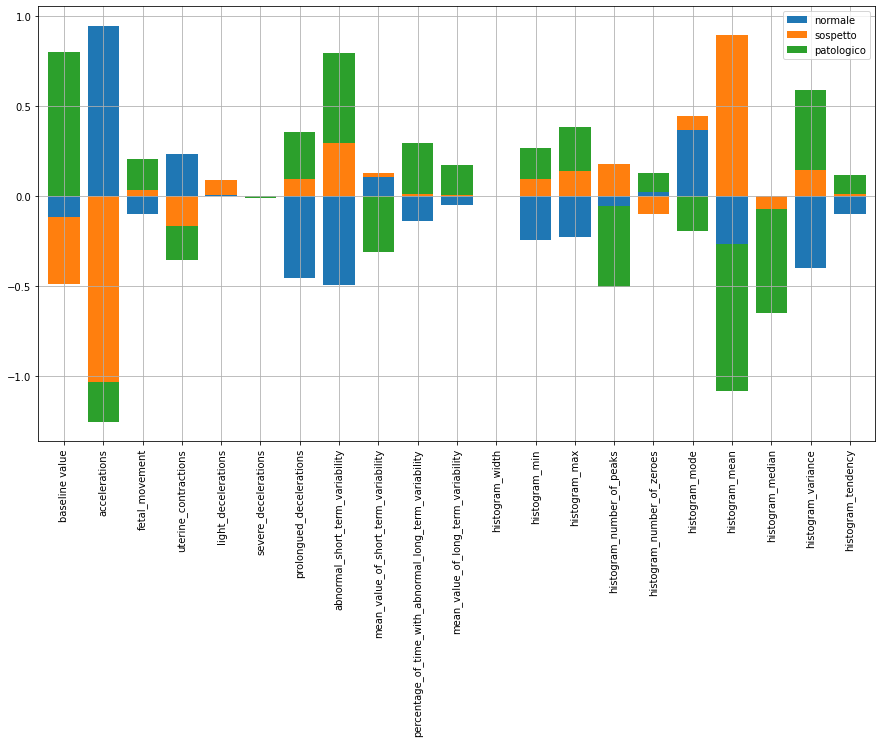

In [137]:
get_features_scores(svm)

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8900 ( 89.00%)

> Intervallo accuratezza (confidenza 95%): 
(0.8648175067191362, 0.9109509108367417)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  533   22    5
2.0   29   61   14
3.0    4    4   37

> Recall:    [0.95178571 0.58653846 0.82222222]
> Precision: [0.94169611 0.70114943 0.66071429]

> f1_score per feature: 
[0.94671403 0.63874346 0.73267327]

> f1_score macro: 0.773
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


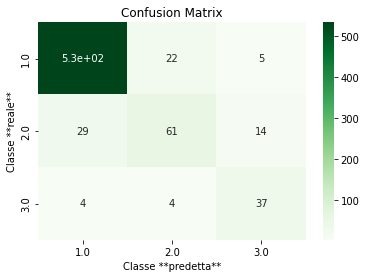

In [138]:
print_eval(X_val, y_val, svm)

Anche in questo caso, forzando il bilanciamento delle classi si ottiene un miglioramento della _Recall_ per le classi 2 e 3 (sospetto e patologico), ma un peggioramento della _Precision_


++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8745 ( 87.45%)

> Intervallo accuratezza (confidenza 95%): 
(0.8480471585918242, 0.8968588626055919)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  504   47    9
2.0   11   76   17
3.0    1    4   40

> Recall:    [0.9        0.73076923 0.88888889]
> Precision: [0.97674419 0.5984252  0.60606061]

> f1_score per feature: 
[0.93680297 0.65800866 0.72072072]

> f1_score macro: 0.772
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


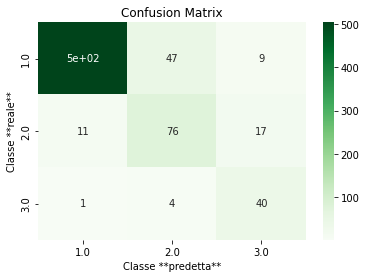

In [139]:
svm_balanced = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", LinearSVC(
        multi_class="ovr", 
        dual=False, 
        random_state=42,
        C=100.0,
        class_weight="balanced",
        penalty="l1"))
])
svm_balanced.fit(X_train, y_train)
print_eval(X_val, y_val, svm_balanced)

### DecisionTreeClassifier
---
[DecisionTreeClassifier doc](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [140]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

- `max_depth` (default=`None`): La massima profondità dell'albero;
- `min_samples_split` (default=`2`): Il numero minimo di campioni necessari per dividere un nodo interno;
- `min_samples_leaf` (default=`1`): Il numero minimo di campioni necessari per essere in un nodo foglia.





In [141]:
dtree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("dtree", DecisionTreeClassifier(random_state=42))
])

In [142]:
params_grid = {
    "dtree__max_depth": [None, 2, 4, 6, 8, 10],
    "dtree__min_samples_leaf": np.arange(1, 10),
    "dtree__min_samples_split": np.arange(2, 12, 2),
    "dtree__class_weight": [None, "balanced"]
}

In [143]:
%%time
dtree, dtree_best_params, dtree_ranking = \
    get_tuned_model(dtree_model, params_grid, X_train, y_train)

CPU times: user 36.8 s, sys: 124 ms, total: 36.9 s
Wall time: 36.8 s


In [144]:
dtree_best_params

{'dtree__class_weight': 'balanced',
 'dtree__max_depth': None,
 'dtree__min_samples_leaf': 1,
 'dtree__min_samples_split': 2}

In [145]:
dtree_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtree__class_weight,param_dtree__max_depth,param_dtree__min_samples_leaf,param_dtree__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
270,0.012225,0.000178,0.002195,0.000051,balanced,None,1,2,"{'dtree__class_weight': 'balanced', 'dtree__ma...",0.894366,0.908451,0.883392,0.939929,0.943463,0.913920,0.024056,1
181,0.011707,0.000200,0.002214,0.000094,None,8,1,4,"{'dtree__class_weight': None, 'dtree__max_dept...",0.880282,0.890845,0.908127,0.929329,0.943463,0.910409,0.023436,2
275,0.012729,0.001158,0.002362,0.000121,balanced,None,2,2,"{'dtree__class_weight': 'balanced', 'dtree__ma...",0.897887,0.890845,0.890459,0.939929,0.932862,0.910397,0.021509,3
276,0.011945,0.000284,0.002194,0.000049,balanced,None,2,4,"{'dtree__class_weight': 'balanced', 'dtree__ma...",0.897887,0.890845,0.890459,0.939929,0.932862,0.910397,0.021509,3
139,0.010375,0.000458,0.002087,0.000101,None,6,1,10,"{'dtree__class_weight': None, 'dtree__max_dept...",0.873239,0.894366,0.908127,0.929329,0.943463,0.909705,0.024868,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0.007358,0.000114,0.002033,0.000044,balanced,2,7,4,"{'dtree__class_weight': 'balanced', 'dtree__ma...",0.816901,0.845070,0.826855,0.855124,0.798587,0.828507,0.020077,511
345,0.007399,0.000185,0.002242,0.000404,balanced,2,7,2,"{'dtree__class_weight': 'balanced', 'dtree__ma...",0.816901,0.845070,0.826855,0.855124,0.798587,0.828507,0.020077,511
344,0.007741,0.001264,0.001962,0.000061,balanced,2,6,10,"{'dtree__class_weight': 'balanced', 'dtree__ma...",0.816901,0.845070,0.826855,0.855124,0.798587,0.828507,0.020077,511
342,0.007330,0.000175,0.002121,0.000073,balanced,2,6,6,"{'dtree__class_weight': 'balanced', 'dtree__ma...",0.816901,0.845070,0.826855,0.855124,0.798587,0.828507,0.020077,511


++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.9238 ( 92.38%)

> Intervallo accuratezza (confidenza 95%): 
(0.9019458659502861, 0.9411586891149626)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  532   22    6
2.0   22   81    1
3.0    3    0   42

> Recall:    [0.95       0.77884615 0.93333333]
> Precision: [0.9551167  0.78640777 0.85714286]

> f1_score per feature: 
[0.95255148 0.7826087  0.89361702]

> f1_score macro: 0.876
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


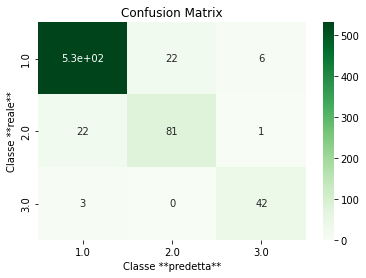

In [146]:
print_eval(X_val, y_val, dtree)

Come si può notare, l'uso di alberi decisionali aumenta considerevolmente precisione e _recall_, nonché lo _score F1_. 

### XGBClassifier
---
[XGBClassifier doc](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier), [XGBoost Parameters doc](https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters)


In [147]:
import xgboost
from xgboost import XGBClassifier

In [148]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [149]:
np.unique(classes_weights)

array([0.43135464, 2.47294939, 3.60559796])

- `objective`: vedi [qui](https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters);
- `n_estimators`: il numero di esecuzioni che XGBoost cercherà di apprendere;
- `reg_alpha`: peso della regolarizzazione L1
- `reg_lambda`: peso della regolarizzazione L2

In [150]:
xgb_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(objective="multi:softprob", random_state=42))
])

In [151]:
params_grid = {
    'xgb__n_estimators': [150, 300],
    'xgb__learning_rate': [0.3, 0.6, 0.9],
    'xgb__reg_alpha': [0, 0.3, 0.6, 1],
    'xgb__reg_lambda': [0, 0.3, 0.6, 1]
}

**Nota Bene**: L'addestramento impiega circa 3 minuti.

In [152]:
%%time
xgb, xgb_best_params, xgb_ranking = \
    get_tuned_model(xgb_model, params_grid, X_train, y_train)

CPU times: user 3min 17s, sys: 1.32 s, total: 3min 18s
Wall time: 3min 17s


In [153]:
xgb_best_params

{'xgb__learning_rate': 0.3,
 'xgb__n_estimators': 300,
 'xgb__reg_alpha': 0,
 'xgb__reg_lambda': 1}

In [154]:
xgb_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__n_estimators,param_xgb__reg_alpha,param_xgb__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.753456,0.013489,0.011286,0.000265,0.3,300,0,1,"{'xgb__learning_rate': 0.3, 'xgb__n_estimators...",0.936620,0.943662,0.939929,0.968198,0.975265,0.952735,0.015829,1
7,0.399188,0.006862,0.006932,0.000167,0.3,150,0.3,1,"{'xgb__learning_rate': 0.3, 'xgb__n_estimators...",0.936620,0.940141,0.929329,0.968198,0.978799,0.950617,0.019298,2
51,0.697172,0.028300,0.011168,0.000852,0.6,300,0,1,"{'xgb__learning_rate': 0.6, 'xgb__n_estimators...",0.940141,0.940141,0.932862,0.964664,0.975265,0.950615,0.016368,3
18,0.743635,0.009898,0.011149,0.000412,0.3,300,0,0.6,"{'xgb__learning_rate': 0.3, 'xgb__n_estimators...",0.929577,0.943662,0.936396,0.964664,0.975265,0.949913,0.017295,4
22,0.571171,0.013963,0.007862,0.000258,0.3,300,0.3,0.6,"{'xgb__learning_rate': 0.3, 'xgb__n_estimators...",0.940141,0.936620,0.932862,0.964664,0.975265,0.949910,0.016872,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.397796,0.007386,0.005141,0.000069,0.9,300,0.3,0,"{'xgb__learning_rate': 0.9, 'xgb__n_estimators...",0.936620,0.926056,0.918728,0.954064,0.975265,0.942147,0.020380,91
59,0.424988,0.008623,0.005542,0.000047,0.6,300,0.6,1,"{'xgb__learning_rate': 0.6, 'xgb__n_estimators...",0.936620,0.926056,0.925795,0.954064,0.968198,0.942147,0.016598,91
43,0.265648,0.005055,0.005049,0.000513,0.6,150,0.6,1,"{'xgb__learning_rate': 0.6, 'xgb__n_estimators...",0.936620,0.926056,0.925795,0.954064,0.968198,0.942147,0.016598,91
63,0.408934,0.004762,0.005285,0.000158,0.6,300,1,1,"{'xgb__learning_rate': 0.6, 'xgb__n_estimators...",0.936620,0.919014,0.925795,0.950530,0.975265,0.941445,0.019988,95


++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.9563 ( 95.63%)

> Intervallo accuratezza (confidenza 95%): 
(0.9386064664322059, 0.9690285537461899)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  546   12    2
2.0   14   88    2
3.0    1    0   44

> Recall:    [0.975      0.84615385 0.97777778]
> Precision: [0.97326203 0.88       0.91666667]

> f1_score per feature: 
[0.97413024 0.8627451  0.94623656]

> f1_score macro: 0.928
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


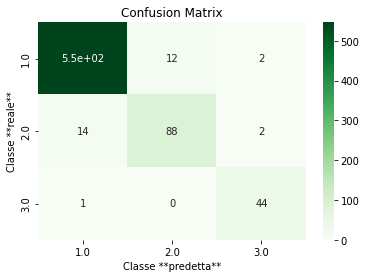

In [155]:
print_eval(X_val, y_val, xgb)

## Confronto tra modelli

Dati due modelli diversi, per determinare se l'accuratezza $a_1$ misurata su uno sia significativamente migliore dell'accuratezza $a_2$ misurata sull'altro, si stima l'intervallo di confidenza della differenza di accuretezza tra i due modelli, valutati entrambi sul _validation set_. Se l'intervallo ottenuto non include lo zero (l'estremo inferiore è positivo), abbiamo la certezza al 95\% (o altro livello di confidenza) che il modello con accuratezza stimata maggiore sia effettivamente migliore.

In [156]:
from scipy.stats import norm

In [157]:
def diff_interval(a1, a2, N1, N2, Z):
    '''
    Compute the confidence interval of the difference of two models, whose 
    parameters are given in input.

        Parameters:
            a1: the accuracy of the fist model
            a2: the accuracy of the second model
            N1: no. of rows (observations) in the validation set for 1st model
            N2: no. of rows (observations) in the validation set for 2nd model
            Z: z distribution

        Returns:
            a tuple with the confidence interval of the difference of the two 
            models
    '''
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

In [158]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    '''
    Compute the confidence interval of the difference in accuracy between
    two models, both evaluated on the given validation set.

        Parameters:
            m1: the first model
            m2: the second model
            X: the validation set
            y: the validation set of the target
            level (default=0.95): a level of accuracy.

        Returns:
            a tuple with the estimated confidence interval of the difference
    '''
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1+level) / 2)
    return diff_interval(a1, a2, N, N, Z)

In [159]:
model_names = ["perceptron", "logistic", "svm", "decision_tree", "xgboost"]
models = [perceptron, logistic, svm, dtree, xgb]
n_models = len(models)

In [161]:
scores = np.empty((n_models, n_models), dtype=object)
for m1, i in zip(models, range(n_models)):
    for m2, j in zip(models, range(n_models)):
        scores[i, j] = model_diff_interval(m1, m2, X_val, y_val)
scores = np.tril(scores, -1) # to display only the matrix lower triangle
scores = pd.DataFrame(scores, columns=model_names, index=model_names)
scores

,perceptron,logistic,svm,decision_tree,xgboost
perceptron,0,0,0,0,0
logistic,"(0.006730147547965595, 0.07507521211352956)",0,0,0,0
svm,"(-0.0007592436876475497, 0.06846023099371232)","(-0.025055731760262358, 0.03916010411569274)",0,0,0
decision_tree,"(0.035319302007507554, 0.10008267260462222)","(-0.002894419214831065, 0.05649103416546568)","(0.0036556269623360844, 0.06404536034372892)",0,0
xgboost,"(0.07024320411288083, 0.13003888333422767)","(0.03227607005666214, 0.08620065772895122)","(0.038776240246728794, 0.09380485989431495)","(0.007786925398009816, 0.05709318743696892)",0


## Conclusioni

Repiloghiamo lo _score_ di accuratezza ottenuto da ciascun modello:

|        Modello         |      Score    |
|------------------------|:-------------:|
| Perceptron             |     0.8561    |
| Logistic Regression    |     0.8970    |
| Support Vector Machine |     0.8900    |
| Decision Tree          |     0.9238    |
| XGBoost                |     0.9563    |

Come si può osservare dalla matrice contente l'intervallo di confidenza della differenza di accuratezza tra tutte le coppie di modelli:
- _SVM_ non è significativamente migliore di _Perceptron_;
- la _Logistic Regression_ è migliore di _Perceptron_, ma non è significativamente migliore di _SVM_
- _Decision Tree_ è migliore di _Perceptron_ e _SVM_ ma non della _Regressione Logistica_
- **_XGBoost_** è significativamente **migliore** di **tutti** gli altri modelli.

Concludendo, **_XGBoost_** risulta essere il miglior modello che classifica le istanze del problema con un intervallo di accuratezza compreso tra il 93,8% e il 96,9% con un livello di confidenza del 95%.